# Data from Analise's Thesis

In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
from src.plot_utils import PlotUtils
from src.analise_thesis.channel_data import ChannelData
from src.analise_thesis.weighted_average import WeightedAverage
from src.analise_thesis.restructure import Restructure
import matplotlib.pyplot as plt
from pprint import pprint

### Set general figure parameters

In [14]:
figure_store_path = 'data/figs_sensors_actuators'
PlotUtils.set_user_figure_dir(user_fig_directory=figure_store_path)
nrows = 1
ncols = 1
title = ''
ylabel = 'R [K$\Omega$]'
xlabel_prefix = "injection number"
xlabel = "injection number"
colors = None
xlim = [0, 5]
ylim = [0, 1e6]
capsize = 10
subplot_config = {'nrows': 1, 'ncols': 1}
SAMPLE_NUM_CUTOFF = 1

### Functions - part 1

In [28]:
def runner(data: list[tuple] = None) -> None:
    if data:
        for datum in data:
            channel_data = ChannelData(channel_width=datum[0], chip_id=datum[1], chip_type=datum[2])
            xdata, ydata, yerr = channel_data.get_data()
            xticks = list(range(1, channel_data.num_injections + 1))
            title = f'Chip type: {datum[2]}, id: {datum[1]}, width: {datum[0]}'
            figname = f'chip_id_{datum[1]}_type_{datum[2]}_width_{datum[0]}.png'
            PlotUtils.plot_scatter(xdata, ydata, yerr=yerr, nrows=nrows, ncols=ncols, figname=figname, 
                                   title=title, capsize=capsize, xlabel=xlabel, ylabel=ylabel, 
                                   xticks=xticks, colors=None)
            
def filter_by_width(data: list[tuple], width: int = None) -> list:
    return list(filter(lambda x: x[0] == width, data))
            
            
def sort_tuples(data: list, idx_to_sort_by: int = 0) -> list | None:
    if data:
        return data.sort(key=lambda x: x[idx_to_sort_by])
    else:
        return None

### Functions - part 2

In [29]:
def get_channel_list(data: list[tuple]) -> list:
    """Return a set (but cast as a list)of channel widths"""
    channels = list(set(tup[0] for tup in data))
    return sorted(channels)

def is_channel_triaged(channel_list: list[tuple]) -> bool:
    """Return true of the number of samples for a given channel width is less than 2"""
    return len(channel_list) < SAMPLE_NUM_CUTOFF

def aggregate_ydata_yerr_from_one_channel(channel_data: list) -> list:
    """Return a list of ydata and yerr from one channel width"""
    xdata = []
    ydata_aggregated = []
    for channel_datum in channel_data:
        print(f'aggregate from channel_datum: {channel_datum}')
        xdata_, ydata, yerr = channel_datum.get_data()
        if len(xdata_) > len(xdata):
            xdata = xdata_
        print(f'xdata: {xdata}\nydata: {ydata}\nyerr: {yerr}\n')
        ydata_aggregated.append((ydata, yerr))
    return xdata, ydata_aggregated

def get_averaged_channel_data(data: list[tuple]) -> dict:
    out_data = {}
    channels = get_channel_list(data)
    for channel in channels:
        print(f'\nProcessing: {channel}')
        chips = filter_by_width(data, channel)
        if is_channel_triaged(chips):
            print(f'width {channel} has less than {SAMPLE_NUM_CUTOFF} samples - triaged')
            continue
        channel_data = []
        chip_counter = 0
        for chip in chips:
            chip_counter += 1
            print(f'processing chip: {chip}')
            channel_data.append(ChannelData(channel_width=chip[0], chip_id=chip[1], chip_type=chip[2]))
        
        # Aggregate data:
        xdata, ydata__aggregated = aggregate_ydata_yerr_from_one_channel(channel_data)
        for d in ydata__aggregated:
            print(f'item in ydata__aggregated: {d}')
        
        # Restructure data:
        restructured_data = Restructure.restructure(tuple(ydata__aggregated))
        if restructured_data == []:
            continue
        print(f'data type of restructured_data: {str(type(restructured_data))}')
        #pprint(f'restructured_data: {restructured_data}')
        for item in restructured_data:
            pprint(f'item: {item}')
        tups: list = []
        for data in restructured_data:
            weighted_ydata_, weighted_yerr_ = WeightedAverage.get(data)
            tups.append((weighted_ydata_, weighted_yerr_))
            print(f'weighted_ydata_: {weighted_ydata_}, weighted_yerr_: {weighted_yerr_}')
        weighted_ydata, weighted_yerr = PlotUtils.lst_tuples_to_lists(data=tups)
        out_data['x_data'] = xdata
        out_data['number_of_injections'] = len(xdata)
        out_data['y_data'] = weighted_ydata
        out_data['y_err'] = weighted_yerr
        #out_data['weighted_yerr'] = weighted_yerr
        out_data['chip_type'] = chip[2]
        out_data['number_of_chips'] = chip_counter
        out_data['chip_width'] = chip[0]
        title = f'Weighted average: Chip type: {chip[2]}, width: {chip[0]}'
        figname = f'chip_id_{chip[1]}_type_{chip[2]}_width_{chip[0]}_weighted_data.png'
        print(f'printing: {figname}')
        
        # Ticks on the x-axis are the chip widths we measured from:
        xticks = list(range(1, len(xdata) + 1))
        
        PlotUtils.plot_scatter(xdata, weighted_ydata, yerr=weighted_yerr, nrows=nrows, ncols=ncols,
                               figname=figname, title=title, capsize=capsize, xlabel=xlabel, ylabel=ylabel, 
                               xticks=xticks, colors=None)
        
        return out_data
     
# get_averaged_channel_data(filter_by_width(data, 764))

## Hard Channel Data

### Chip width 896 $\mu$m, chip type _hard_

In [30]:
# chip_type = 'hard'
# chip_id = 1
# channel_width = 896
# cd_896 = ChannelData(channel_width=channel_width, chip_id=chip_id, chip_type=chip_type)
# xdata, ydata, yerr = cd_896.get_data()
# xticks = list(range(1, cd_896.num_injections + 1))
# figname = 'junk.png'
# PlotUtils.plot_scatter(xdata, ydata, yerr=yerr, subplot_config=subplot_config, figname=figname, 
#                        capsize=capsize, xlabel=xlabel, ylabel=ylabel, xticks=xticks, colors=None)

In [31]:
data = [
    (896, 1, 'hard'),
    (764, 1, 'hard'),
    (608, 1, 'hard'),
    (512, 1, 'hard'),
    (764, 2, 'hard'),
    (608, 2, 'hard'),
    (512, 2, 'hard'),
    (384, 2, 'hard'),
    (288, 2, 'hard'),
    (996, 3, 'hard'),
    (800, 3, 'hard'),
    (764, 3, 'hard'),
    (764, 4, 'hard'),
    (512, 4, 'hard'),
    (384, 4, 'hard'),
    (192, 4, 'hard'),
    ]
sort_tuples(data=data, idx_to_sort_by=0)
pprint(data)
# special = filter_by_width(data, 764)
# print(special)

[(192, 4, 'hard'),
 (288, 2, 'hard'),
 (384, 2, 'hard'),
 (384, 4, 'hard'),
 (512, 1, 'hard'),
 (512, 2, 'hard'),
 (512, 4, 'hard'),
 (608, 1, 'hard'),
 (608, 2, 'hard'),
 (764, 1, 'hard'),
 (764, 2, 'hard'),
 (764, 3, 'hard'),
 (764, 4, 'hard'),
 (800, 3, 'hard'),
 (896, 1, 'hard'),
 (996, 3, 'hard')]


### Create plots for each data tuple

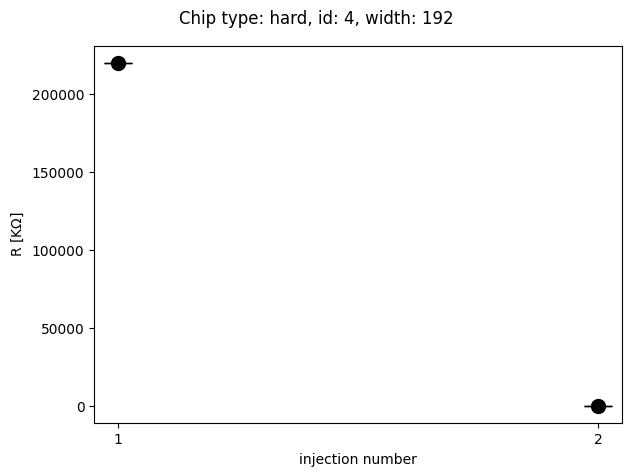

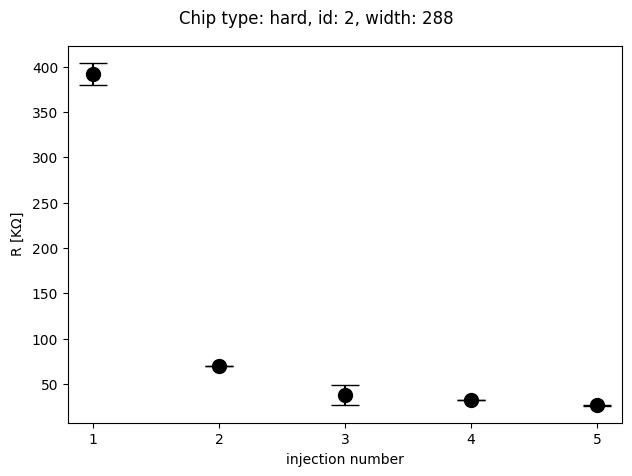

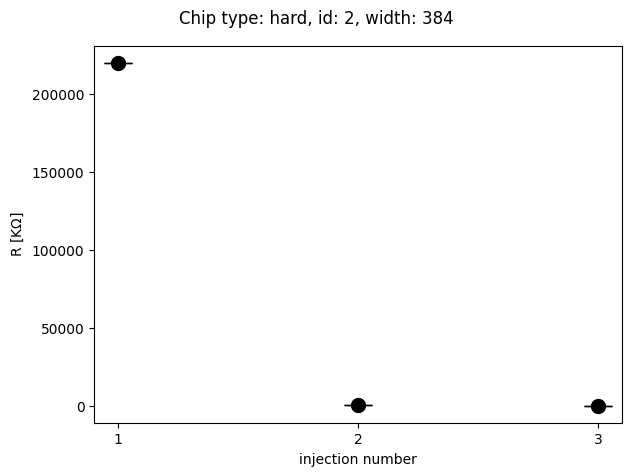

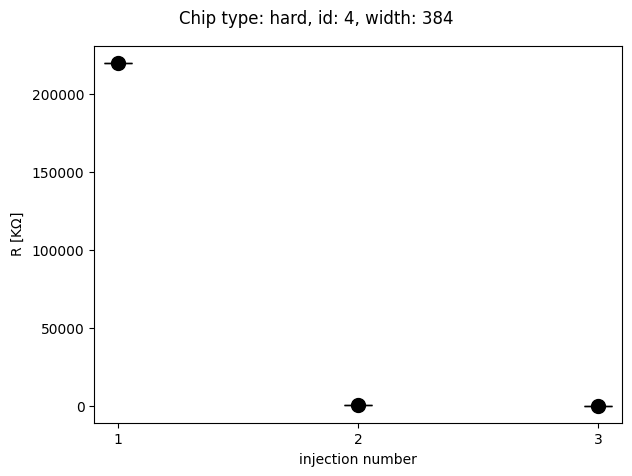

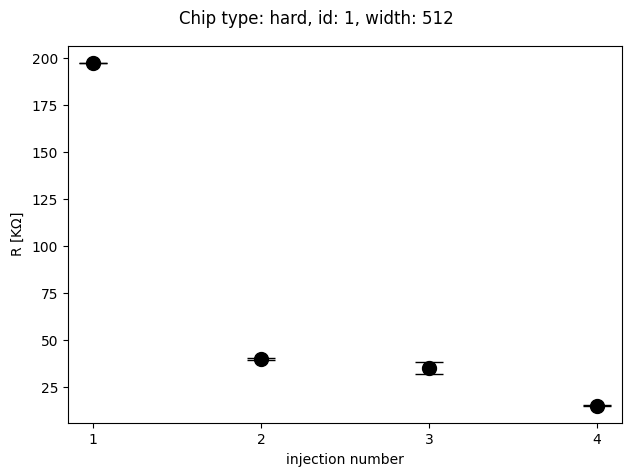

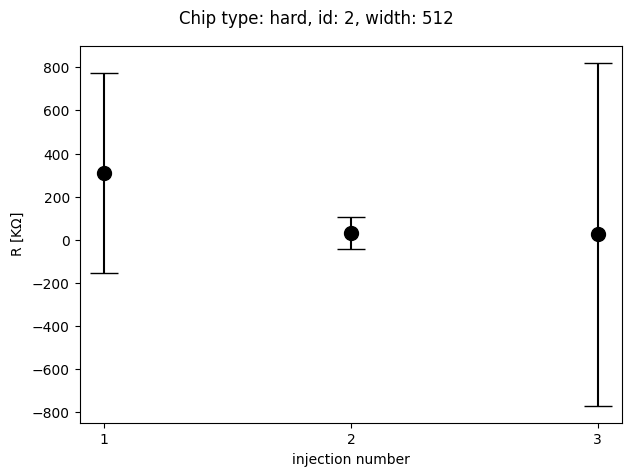

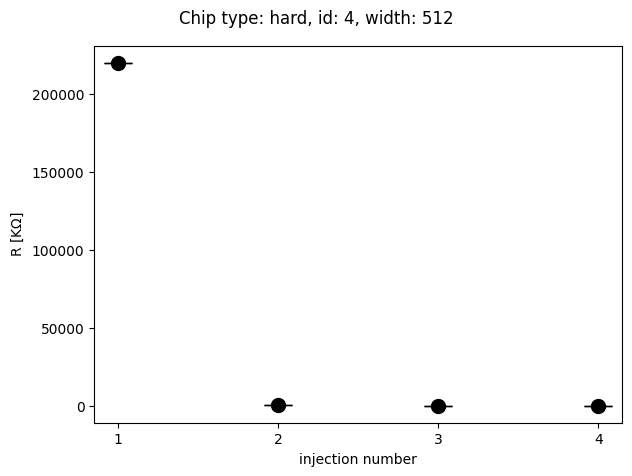

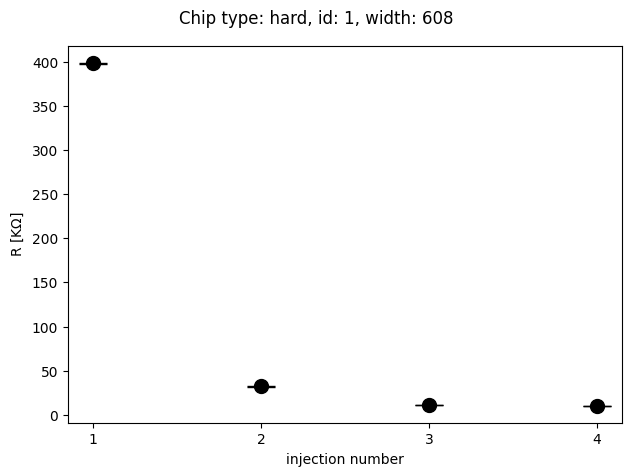

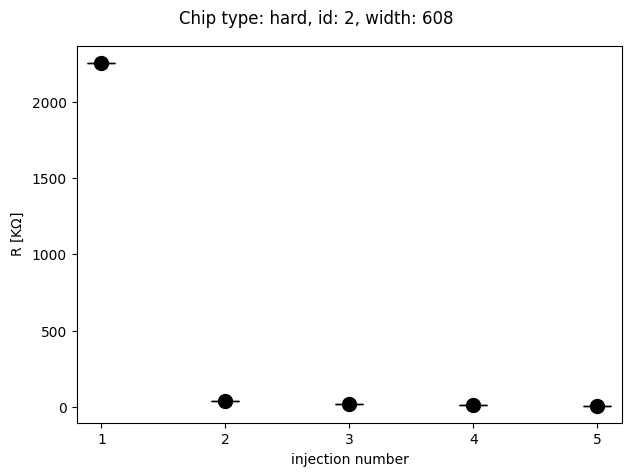

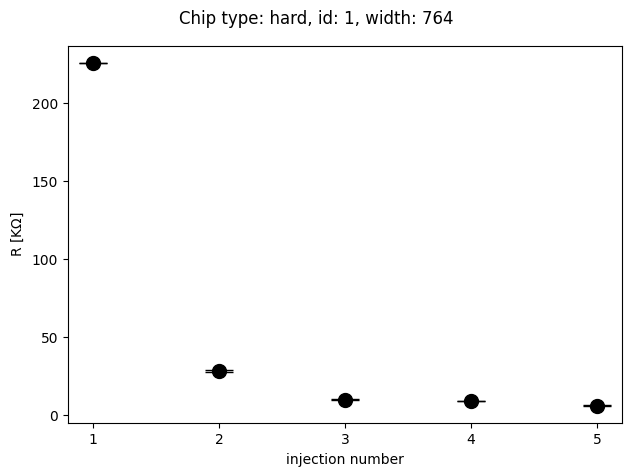

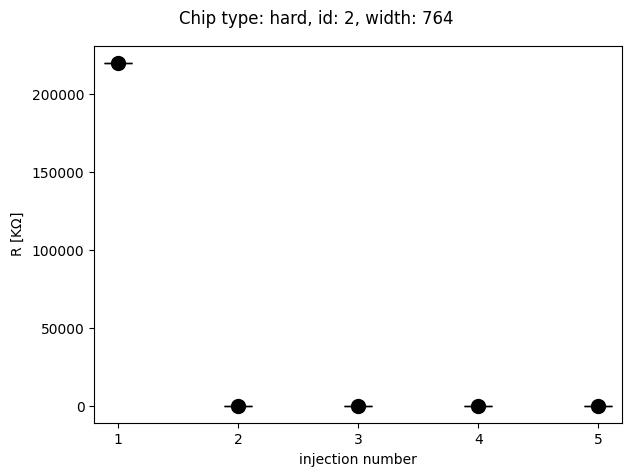

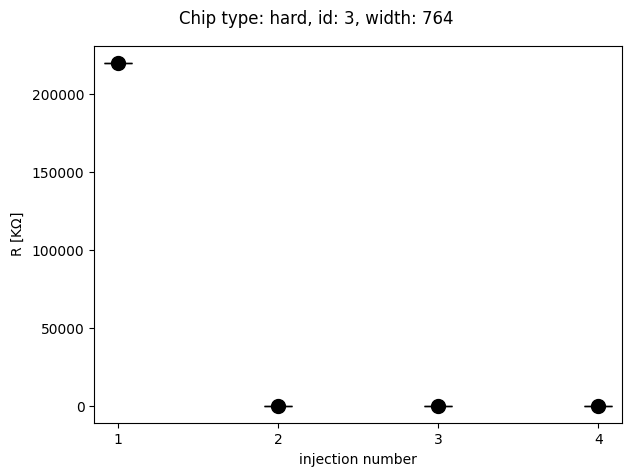

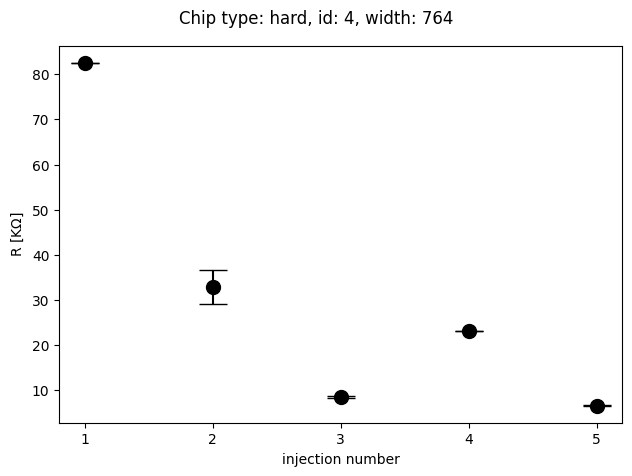

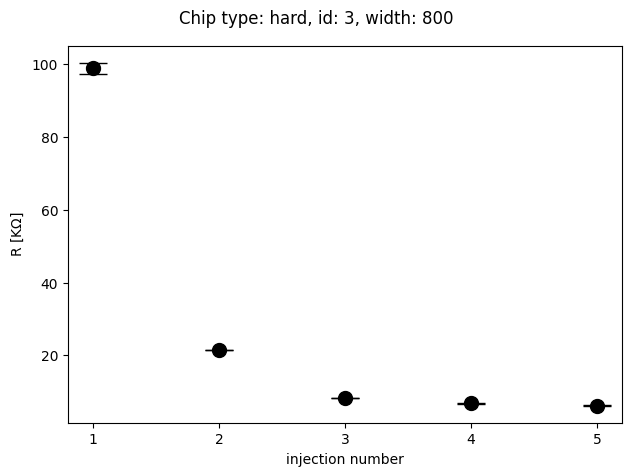

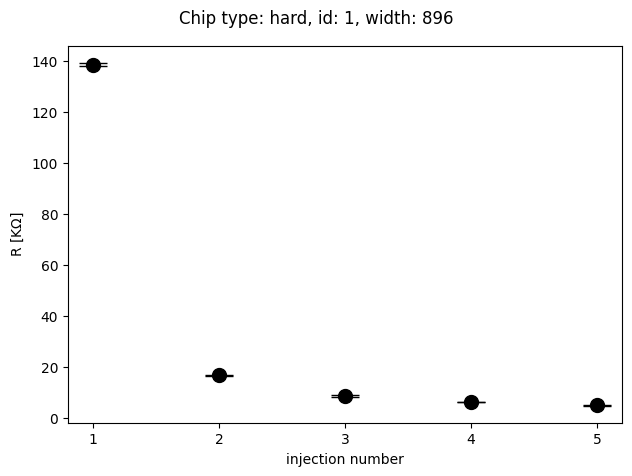

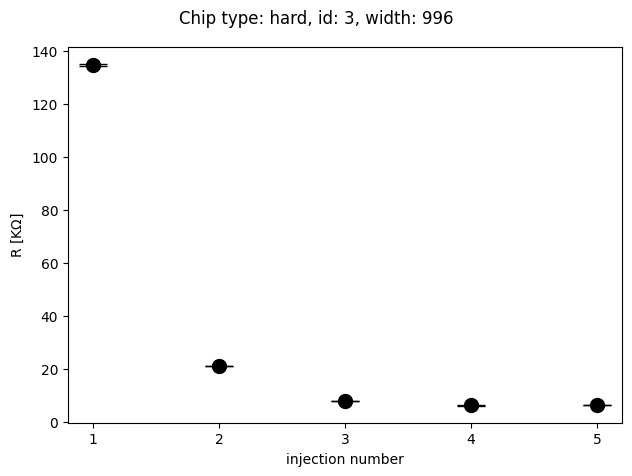

In [32]:
runner(data=data)

### Create a Pandas Dataframe for all _hard_ data


Processing: 192
processing chip: (192, 4, 'hard')
aggregate from channel_datum: Channel Data: width: 192
xdata: [1, 2]
ydata: [220000.0, 198.8]
yerr: [0.0, 0.03857]

item in ydata__aggregated: ([220000.0, 198.8], [0.0, 0.03857])
data type of restructured_data: <class 'list'>
'item: [(220000.0, 0.0)]'
'item: [(198.8, 0.03857)]'
stddevs: [10.0]
cls.weights: [0.01]
weighted_ydata_: 220000.0, weighted_yerr_: 100.0
stddevs: [0.03857]
cls.weights: [672.2034270409557]
weighted_ydata_: 198.8, weighted_yerr_: 0.38570000000000004
printing: chip_id_4_type_hard_width_192_weighted_data.png

Processing: 288
processing chip: (288, 2, 'hard')
aggregate from channel_datum: Channel Data: width: 288
xdata: [1, 2, 3, 4, 5]
ydata: [391.8, 70.26, 38.02, 32.62, 26.44]
yerr: [12.36, 0.2169, 11.41, 0.2453, 0.1032]

item in ydata__aggregated: ([391.8, 70.26, 38.02, 32.62, 26.44], [12.36, 0.2169, 11.41, 0.2453, 0.1032])
data type of restructured_data: <class 'list'>
'item: [(391.8, 12.36)]'
'item: [(70.26, 0.21


Processing: 996
processing chip: (996, 3, 'hard')
aggregate from channel_datum: Channel Data: width: 996
xdata: [1, 2, 3, 4, 5]
ydata: [134.9, 21.25, 7.928, 6.265, 6.514]
yerr: [0.3484, 0.04319, 0.009346, 0.0653, 0.01494]

item in ydata__aggregated: ([134.9, 21.25, 7.928, 6.265, 6.514], [0.3484, 0.04319, 0.009346, 0.0653, 0.01494])
data type of restructured_data: <class 'list'>
'item: [(134.9, 0.3484)]'
'item: [(21.25, 0.04319)]'
'item: [(7.928, 0.009346)]'
'item: [(6.265, 0.0653)]'
'item: [(6.514, 0.01494)]'
stddevs: [0.3484]
cls.weights: [8.238415798777025]
weighted_ydata_: 134.9, weighted_yerr_: 3.484
stddevs: [0.04319]
cls.weights: [536.0849214268372]
weighted_ydata_: 21.25, weighted_yerr_: 0.4319
stddevs: [0.009346]
cls.weights: [11448.49626062346]
weighted_ydata_: 7.928, weighted_yerr_: 0.09345999999999999
stddevs: [0.0653]
cls.weights: [234.51662605620427]
weighted_ydata_: 6.265, weighted_yerr_: 0.6529999999999999
stddevs: [0.01494]
cls.weights: [4480.214476827435]
weighted_yda

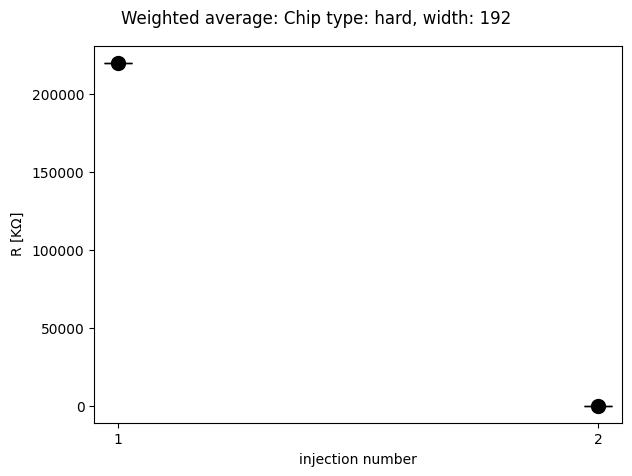

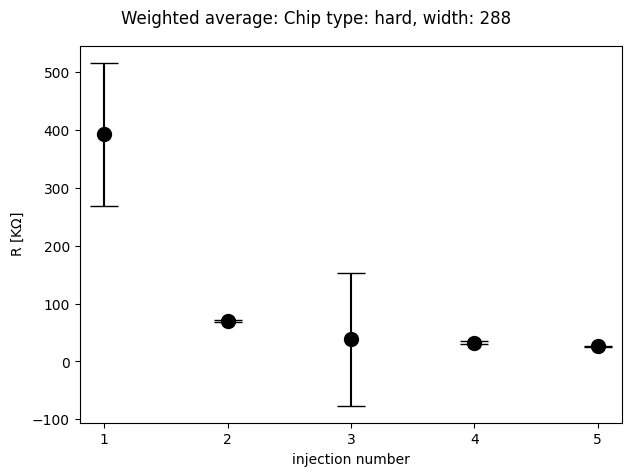

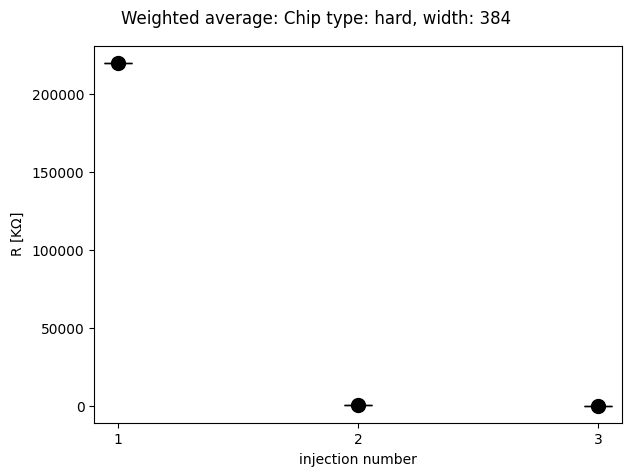

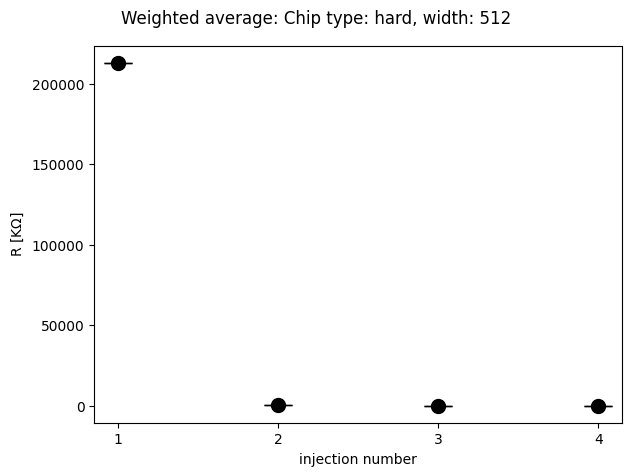

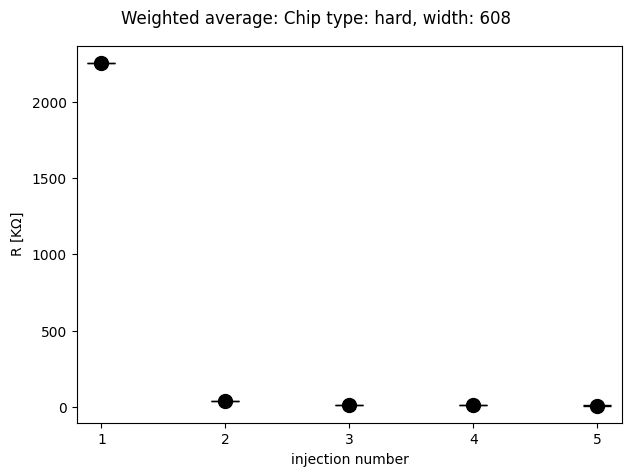

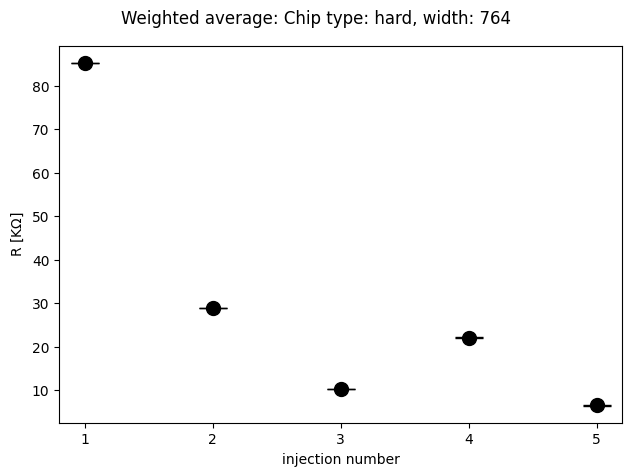

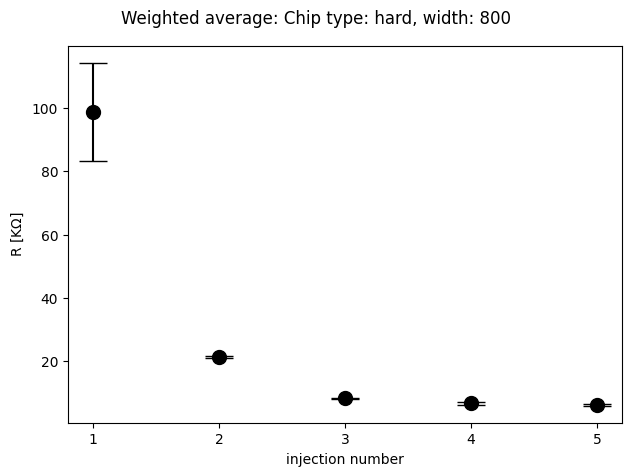

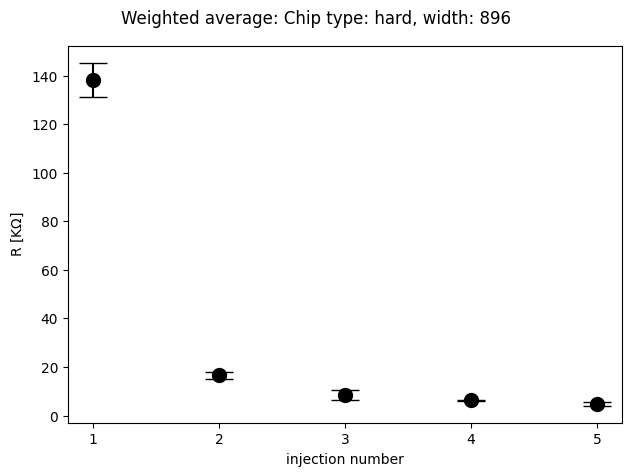

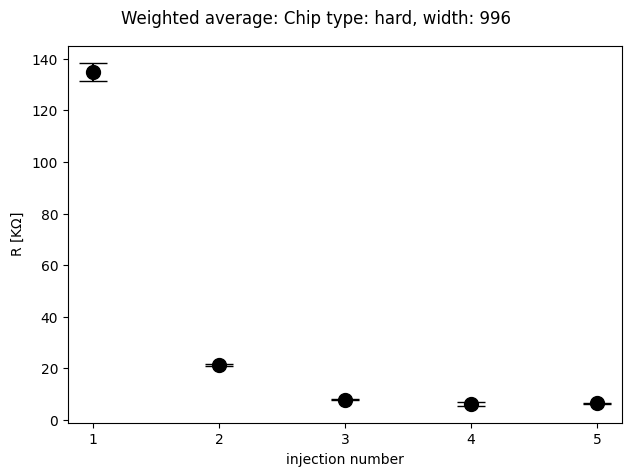

In [33]:
df = pd.DataFrame()
channels = get_channel_list(data)
for channel in channels:
    df_ = pd.DataFrame(get_averaged_channel_data(filter_by_width(data, channel)))
    df = pd.concat([df_, df])

### Print dataframe and write to disk as a CSV file

In [34]:
path = os.path.join(PlotUtils.glob_figpath, 'weighted_data_hard.csv')
df.to_csv(path)
df

,x_data,number_of_injections,y_data,y_err,chip_type,number_of_chips,chip_width
0,1,5,134.900000,3.484000,hard,1,996
1,2,5,21.250000,0.431900,hard,1,996
2,3,5,7.928000,0.093460,hard,1,996
3,4,5,6.265000,0.653000,hard,1,996
4,5,5,6.514000,0.149400,hard,1,996
0,1,5,138.400000,6.969000,hard,1,896
1,2,5,16.590000,1.366000,hard,1,896
2,3,5,8.512000,2.016000,hard,1,896
3,4,5,6.235000,0.349100,hard,1,896
4,5,5,4.833000,0.728000,hard,1,896


### Filter dataframe for the resistance at the last injection

In [35]:
df_last_injection = df.loc[df.x_data == df.number_of_injections]
df_last_injection

,x_data,number_of_injections,y_data,y_err,chip_type,number_of_chips,chip_width
4,5,5,6.514000,0.149400,hard,1,996
4,5,5,4.833000,0.728000,hard,1,896
4,5,5,6.271000,0.206000,hard,1,800
4,5,5,6.576132,0.052175,hard,4,764
4,5,5,8.371000,0.298900,hard,2,608
3,4,4,18.578099,0.132399,hard,3,512
2,3,3,24.374414,0.025275,hard,2,384
4,5,5,26.440000,1.032000,hard,1,288
1,2,2,198.800000,0.385700,hard,1,192


### Summary plots: resistance at each channel after last injection
The number of the last injection is variable, shown in the above tables in column `number_of_injections`.

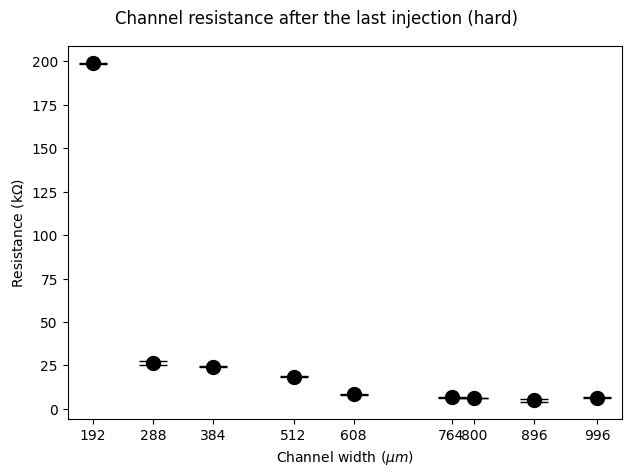

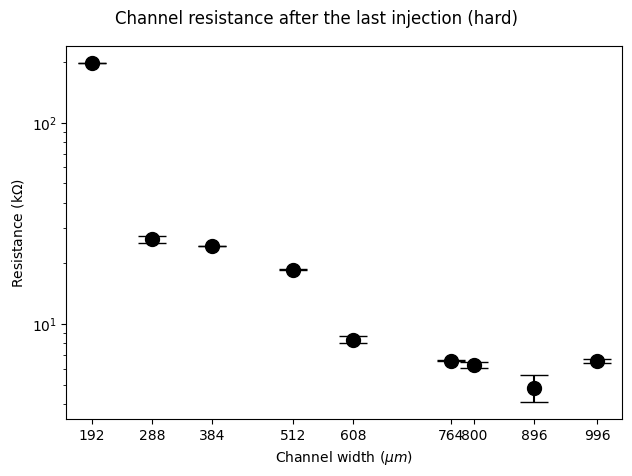

In [36]:
# print(df_last_injection.chip_width.to_list())
title = 'Channel resistance after the last injection (hard)'
xlabel = 'Channel width ($\mu m$)'
ylabel = 'Resistance (k$\Omega$)'
fig_format = 'png'
# with linear y-scale
figname = os.path.join(PlotUtils.glob_figpath, f'resistance_at_last_injection_hard_linear.{fig_format}')
PlotUtils.plot_scatter(df_last_injection.chip_width, df_last_injection.y_data, yerr=df_last_injection.y_err,
                       nrows=nrows, ncols=ncols, xlabel=xlabel, ylabel=ylabel, 
                       xticks=df_last_injection.chip_width.to_list(), title=title, figname=figname,
                       fig_format=fig_format, capsize=capsize)
# with logarithmic y-scale
figname = os.path.join(PlotUtils.glob_figpath, f'resistance_at_last_injection_hard_logarithmic.{fig_format}')
PlotUtils.plot_scatter(df_last_injection.chip_width, df_last_injection.y_data, yerr=df_last_injection.y_err,
                       nrows=nrows, ncols=ncols, xlabel=xlabel, ylabel=ylabel, 
                       xticks=df_last_injection.chip_width.to_list(), title=title, figname=figname,
                       fig_format=fig_format, capsize=capsize, yscale='log')

## Get soft data

In [37]:
data = [
    (720, 1, 'soft'),
    (720, 3, 'soft'),
    (720, 5, 'soft'),
    (720, 6, 'soft'),
    (960, 1, 'soft'),
    (960, 5, 'soft'),
    (840, 1, 'soft'),
    (840, 5, 'soft'),
    (840, 6, 'soft'),
    (1080, 1, 'soft'),
    (1080, 2, 'soft'),
    (1080, 3, 'soft'),
    (1080, 5, 'soft'),
    (1080, 6, 'soft'),
    (1080, 7, 'soft'),
    (600, 2, 'soft'),
    (600, 3, 'soft'),
    (600, 5, 'soft'),
    (480, 2, 'soft'),
]

### Create plots for each data tuple

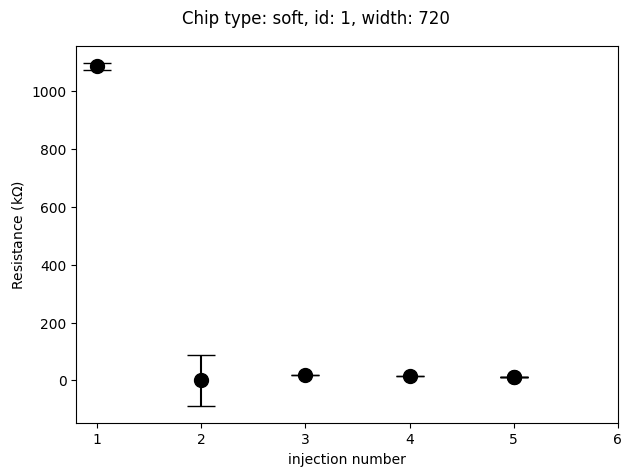

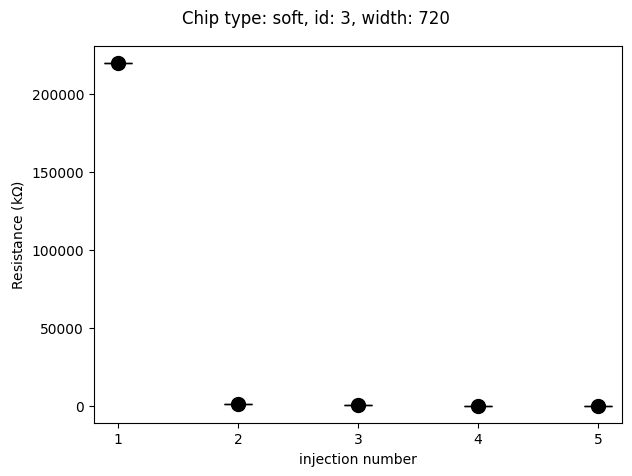

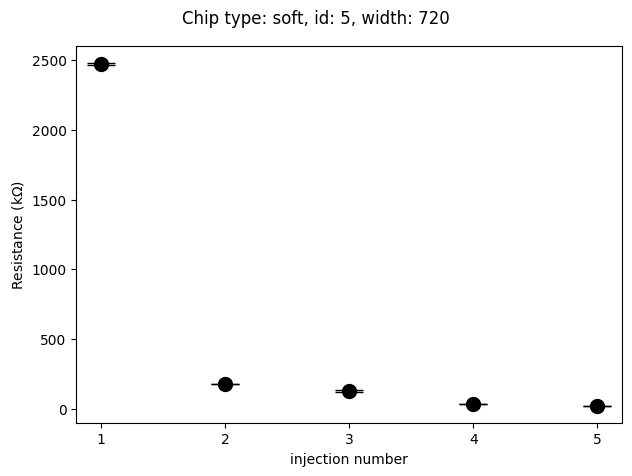

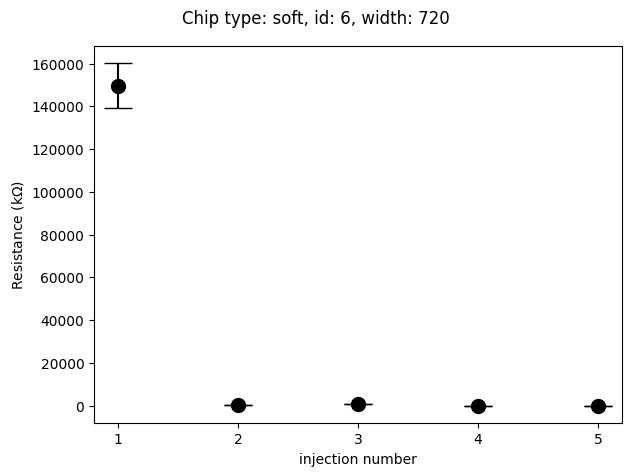

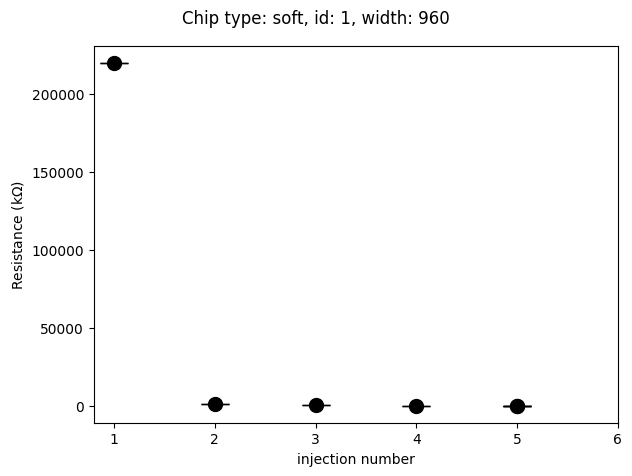

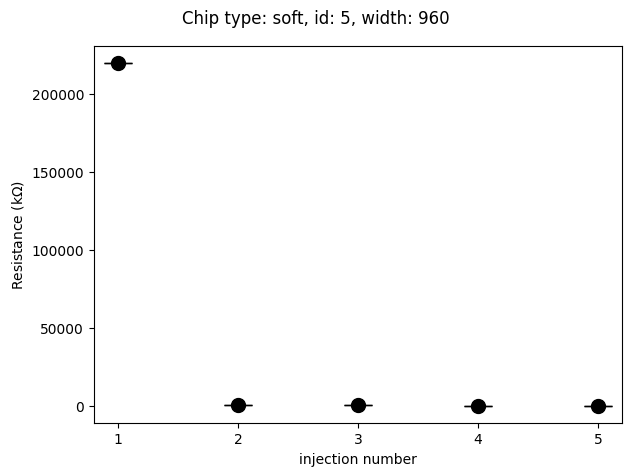

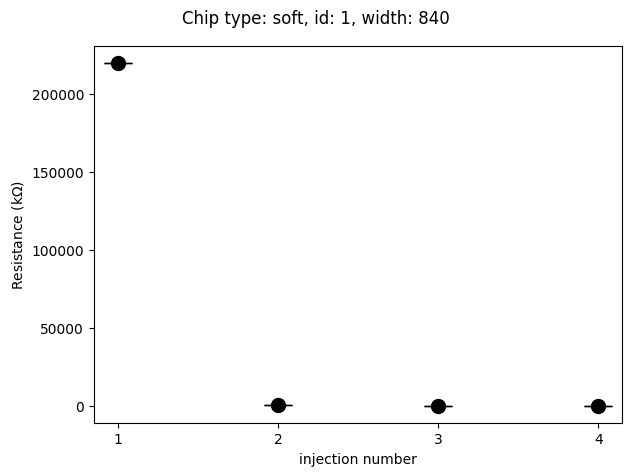

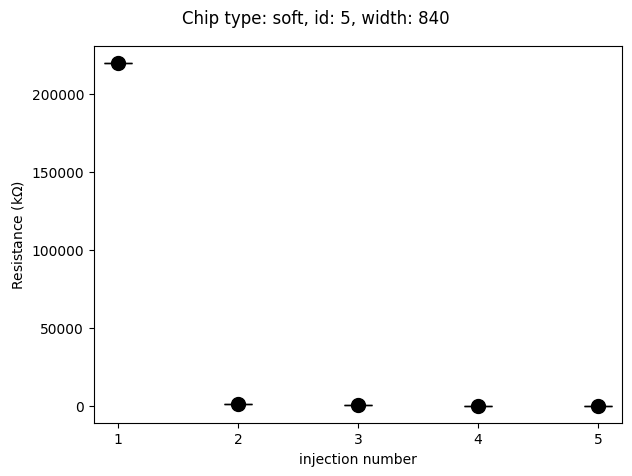

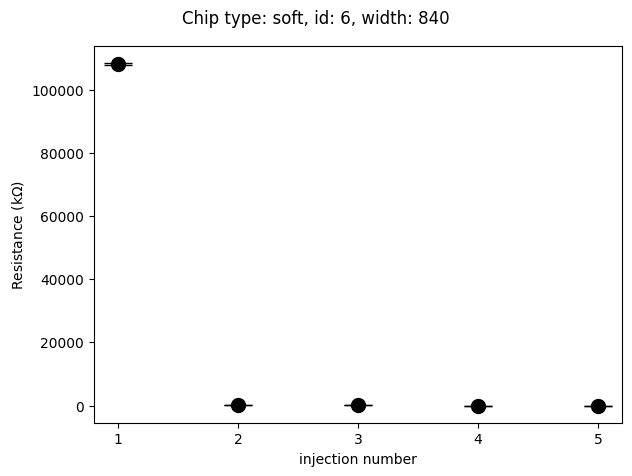

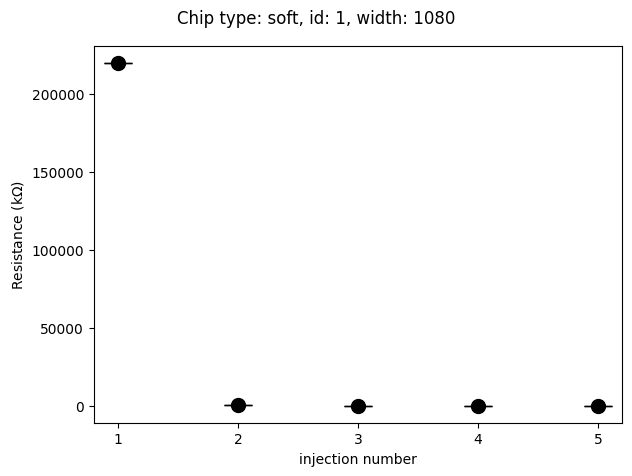

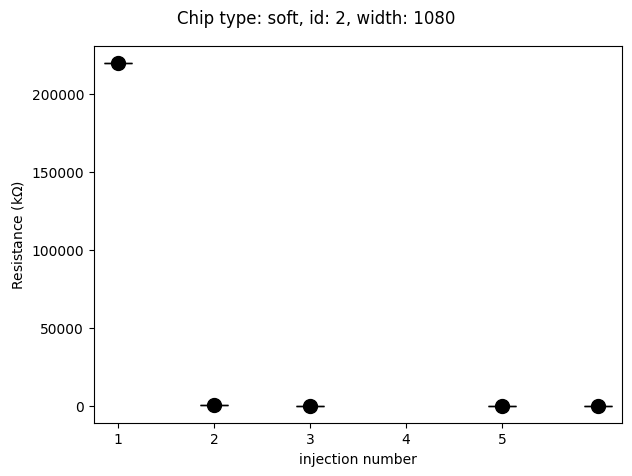

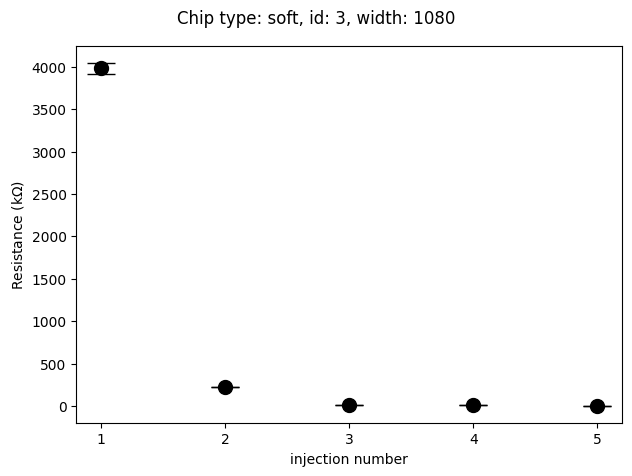

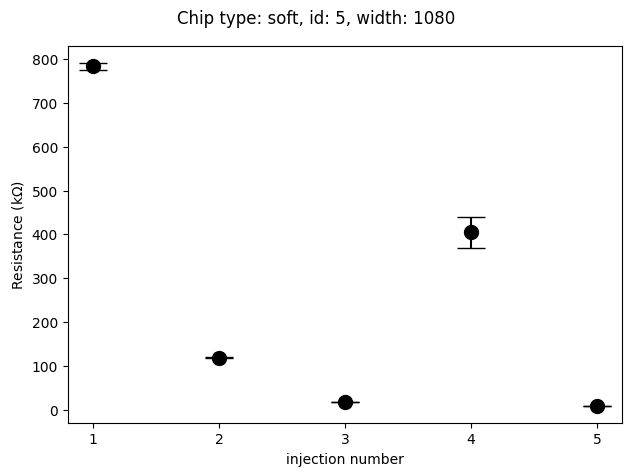

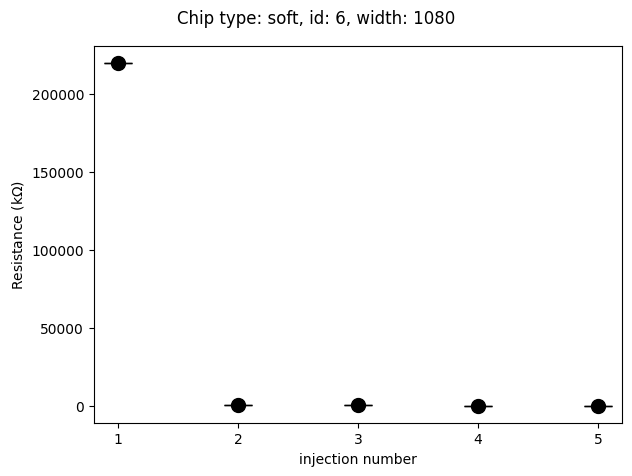

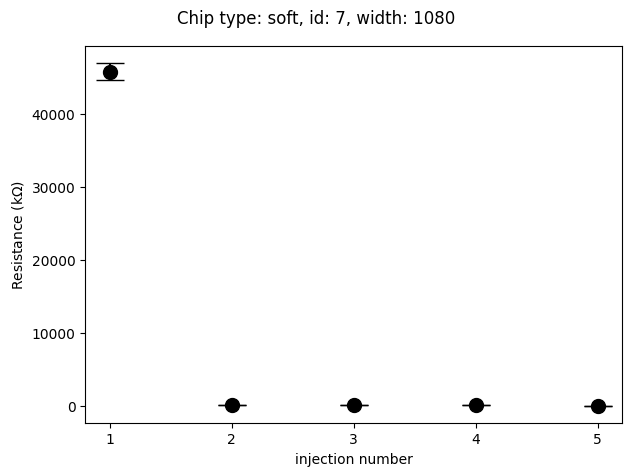

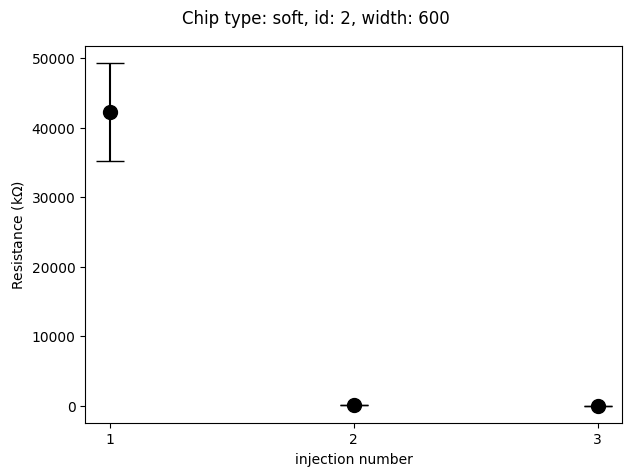

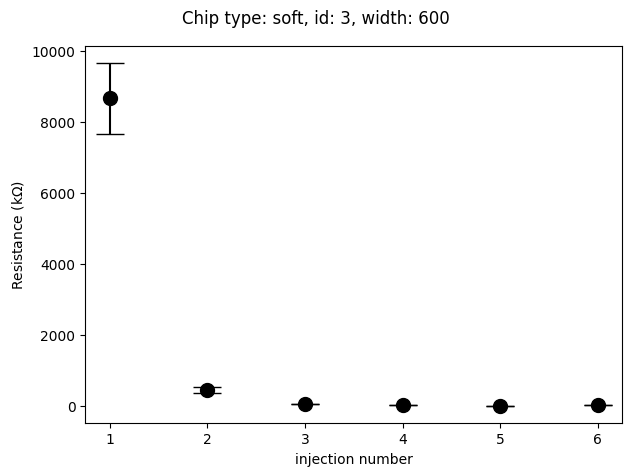

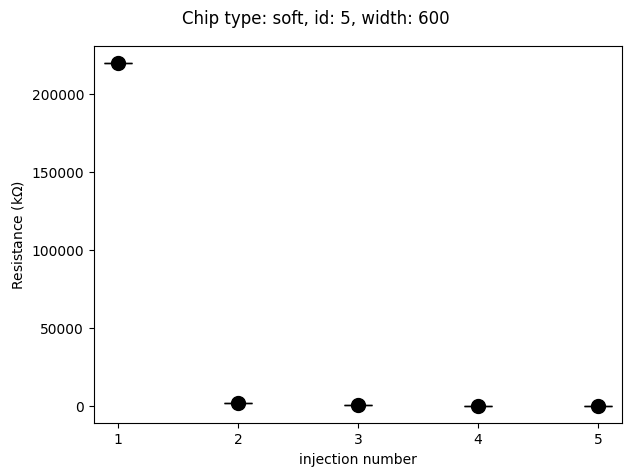

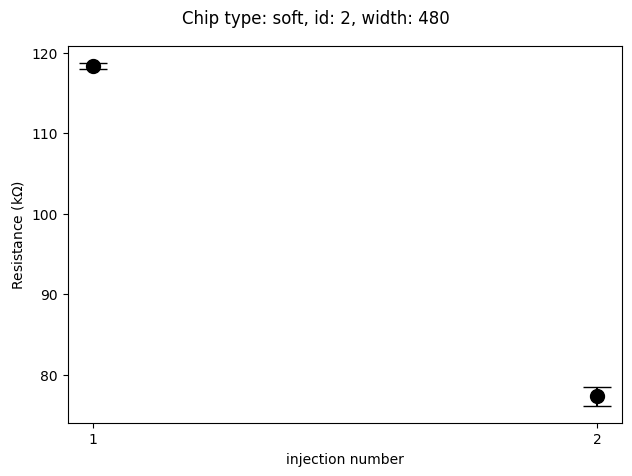

In [38]:
xlabel = "injection number"
runner(data)

[480, 600, 720, 840, 960, 1080]

Processing: 480
processing chip: (480, 2, 'soft')
aggregate from channel_datum: Channel Data: width: 480
xdata: [1, 2]
ydata: [118.4, 77.34]
yerr: [0.3546, 1.166]

item in ydata__aggregated: ([118.4, 77.34], [0.3546, 1.166])
data type of restructured_data: <class 'list'>
'item: [(118.4, 0.3546)]'
'item: [(77.34, 1.166)]'
stddevs: [0.3546]
cls.weights: [7.952845353104742]
weighted_ydata_: 118.4, weighted_yerr_: 3.5460000000000007
stddevs: [1.166]
cls.weights: [0.7355342479456529]
weighted_ydata_: 77.34, weighted_yerr_: 11.659999999999998
printing: chip_id_2_type_soft_width_480_weighted_data.png

Processing: 600
processing chip: (600, 2, 'soft')
processing chip: (600, 3, 'soft')
processing chip: (600, 5, 'soft')
aggregate from channel_datum: Channel Data: width: 600
xdata: [1, 2, 3]
ydata: [42300.0, 122.4, 26.95]
yerr: [7077.0, 0.5537, 0.03176]

aggregate from channel_datum: Channel Data: width: 600
xdata: [1, 2, 3, 4, 5, 6]
ydata: [8674.0, 465.9, 57.92, 

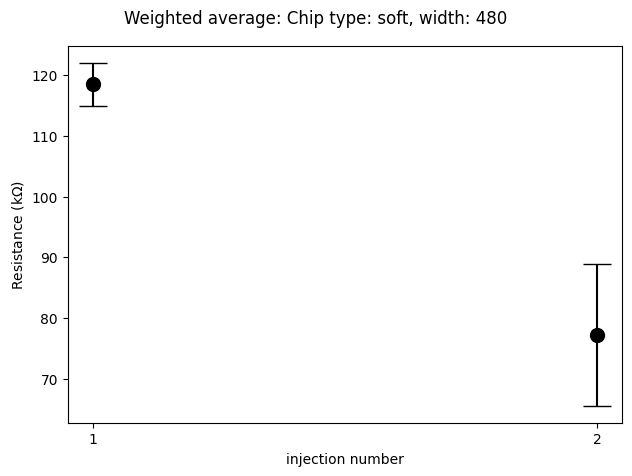

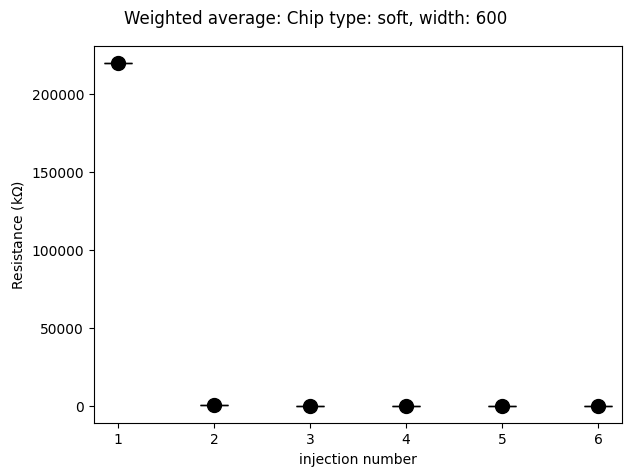

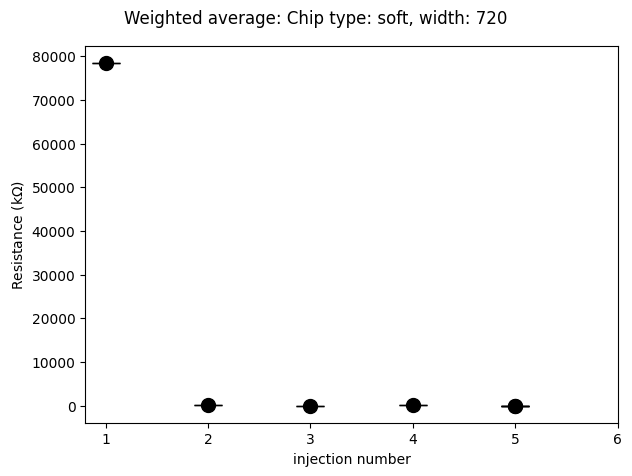

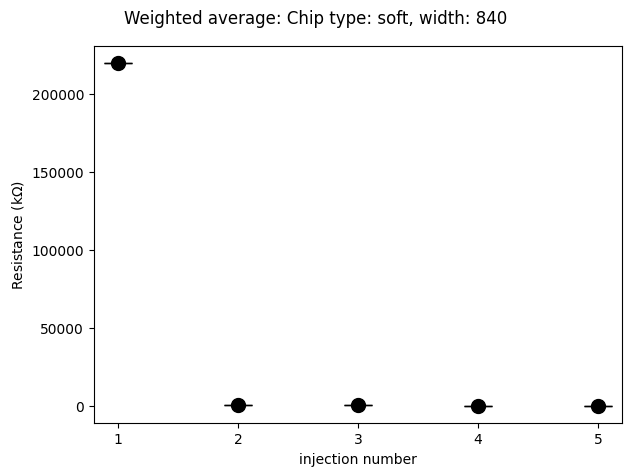

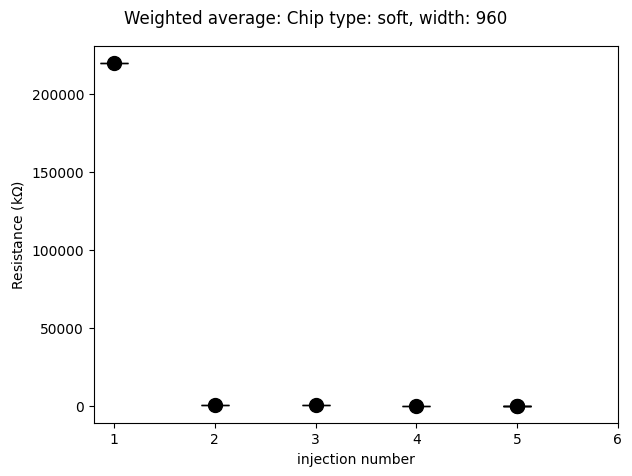

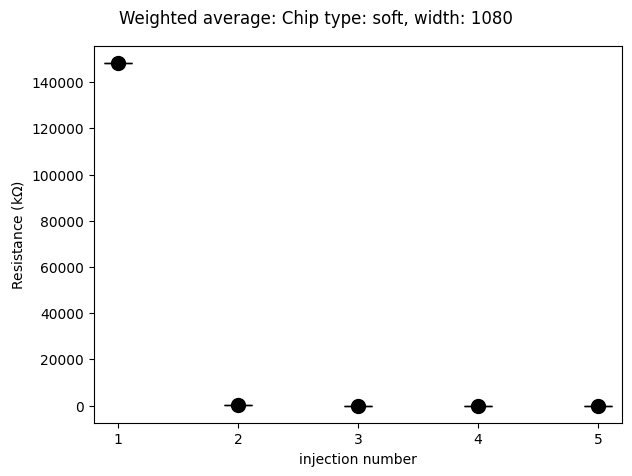

In [39]:
df = pd.DataFrame()
channels = get_channel_list(data)
print(channels)
for channel in channels:
    df_ = pd.DataFrame(get_averaged_channel_data(filter_by_width(data, channel)))
    df = pd.concat([df_, df])

In [40]:
path = os.path.join(PlotUtils.glob_figpath, 'weighted_data_soft.csv')
df.to_csv(path)
df

,x_data,number_of_injections,y_data,y_err,chip_type,number_of_chips,chip_width
0,1,5,148418.663586,22.446144,soft,6,1080
1,2,5,161.129226,1.479176,soft,6,1080
2,3,5,16.771089,0.003759,soft,6,1080
3,4,5,18.827472,0.072578,soft,6,1080
4,5,5,12.066851,0.033734,soft,6,1080
0,1,6,220000.000000,50.000000,soft,2,960
1,2,6,453.724647,1.188805,soft,2,960
2,3,6,158.876657,1.739362,soft,2,960
3,4,6,55.221779,0.045290,soft,2,960
4,5,6,20.889527,0.002296,soft,2,960


### Filter dataframe for last injection

In [41]:
df_last_injection = df.loc[df.x_data == df.number_of_injections]
df_last_injection

,x_data,number_of_injections,y_data,y_err,chip_type,number_of_chips,chip_width
4,5,5,12.066851,0.033734,soft,6,1080
4,5,5,24.857453,1.286486,soft,3,840
5,6,6,28.380000,23.030000,soft,3,600
1,2,2,77.340000,11.660000,soft,1,480


### Summary plots: resistance at each channel after last injection
The number of the last injection is variable, shown in the above tables in column `number_of_injections`.

[1080, 840, 600, 480]


/home/mkrause/dev/artificial-muscle/src/plot_utils.py:108: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(ylim)


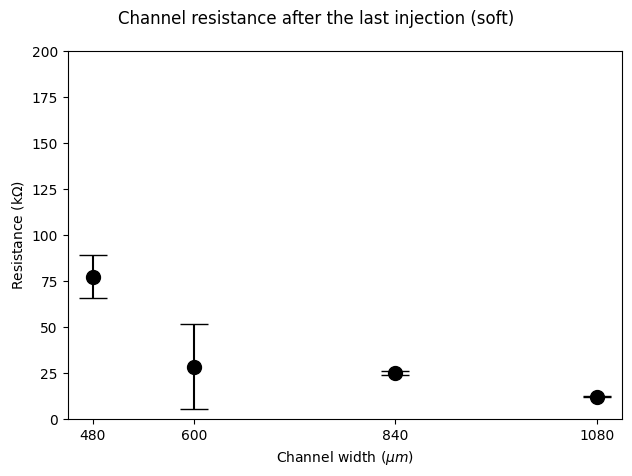

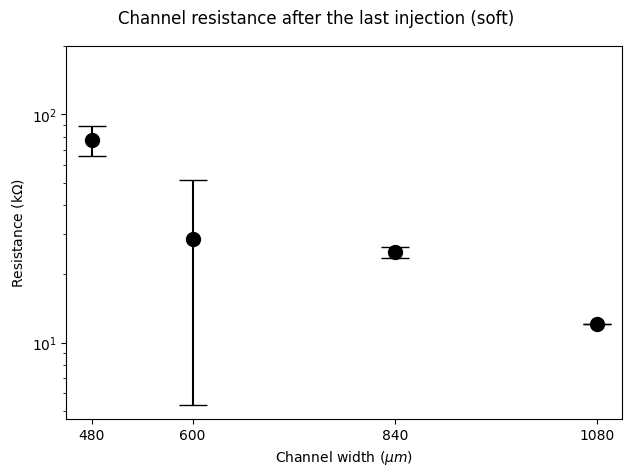

In [42]:
print(df_last_injection.chip_width.to_list())
title = 'Channel resistance after the last injection (soft)'
xlabel = 'Channel width ($\mu m$)'
ylabel = 'Resistance (k$\Omega$)'
fig_format = 'png'

# with linear y-scale
figname = os.path.join(PlotUtils.glob_figpath, f'resistance_at_last_injection_soft_linear.{fig_format}')
PlotUtils.plot_scatter(df_last_injection.chip_width, df_last_injection.y_data, yerr=df_last_injection.y_err, 
                       nrows=nrows, ncols=ncols, xlabel=xlabel, ylabel=ylabel, 
                       xticks=df_last_injection.chip_width.to_list(), title=title, figname=figname,
                       fig_format=fig_format, ylim=[0, 200], capsize=capsize)

# with logrithmic y-scale
figname = os.path.join(PlotUtils.glob_figpath, f'resistance_at_last_injection_soft_logarithmic.{fig_format}')
PlotUtils.plot_scatter(df_last_injection.chip_width, df_last_injection.y_data, yerr=df_last_injection.y_err, 
                       nrows=nrows, ncols=ncols, xlabel=xlabel, ylabel=ylabel, 
                       xticks=df_last_injection.chip_width.to_list(), title=title, figname=figname,
                       fig_format=fig_format, ylim=[0, 200], yscale='log', capsize=capsize)